# Disclaimer: This notebook was run using CDMS kernel V04-00

In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
from qetpy.utils import lowpassfilter 
from qetpy import autocuts
import cdms
#from CDMSDataCatalog import CDMSDataCatalog
import scipy.optimize as optimize
import matplotlib as mpl

/cvmfs/cdms.opensciencegrid.org/releases/centos7/V04-00/lib/python3.7/site-packages/datacat/model.py:2: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import OrderedDict, MutableMapping


In [2]:
import pickle as pkl
import os, sys
import ROOT as rt

Welcome to JupyROOT 6.22/00


In [3]:
#Define processed files
#catalog = CDMSDataCatalog()
#print("Will search for data at ", catalog.default_fetchdir)

base="/sdf/group/supercdms/data/CDMS/CUTE/R37/Processed/Prompt/Prompt_V04-15_P0.2.0/Submerged"
# series = {
#     'prebake' : '23231211_165227',
#     'postbake' : '23231213_115428'
# }

#Prompt_V04-15_P0.2.0_23231212_022833.root
# filePath = {
#     'prebake' : '%s/Prompt_V04-15_P0.2.0_%s.root'%(base,series['prebake']),
#     'postbake' : '%s/Prompt_V04-15_P0.2.0_%s.root'%(base,series['postbake'])
# }


series = {
    'LED' : '23231213_192731'
}

filePath = {
    'LED' : '%s/Prompt_V04-15_P0.2.0_%s.root'%(base,series['LED'])
}

In [4]:
#Get RQs from processed files
### Older version #####
# RQ=[]
# for i in np.arange(9):
#     RQ.append(uproot.open(fetchresult[i].filePath)['rqDir/zip1']) 

# eventTree=[]
# for i in np.arange(9):
#     eventTree.append(uproot.open(fetchresult[i].filePath)['rqDir/eventTree']) 
##################################################################

dets = ['Z1','Z2','Z3']
RQ = []

for key in filePath.keys():
    t = {}
    for i,det in enumerate(dets):
        t[det] = uproot.open(filePath[key])['rqDir/zip%d'%(i+1)]
    RQ.append(t)

eventTree=[]
for key in filePath.keys():
    eventTree.append(uproot.open(filePath[key])['rqDir/eventTree']) 

# RQ=[]
# for i in np.arange(1):
#     RQ.append(uproot.open(filePath)['rqDir/zip1']) 

# eventTree=[]
# for i in np.arange(1):
#     eventTree.append(uproot.open(filePath)['rqDir/eventTree']) 

In [5]:
RQ[0]

{'Z1': <TTree b'zip1' at 0x7f12dbe6dcd0>,
 'Z2': <TTree b'zip2' at 0x7f12d8b94fd0>,
 'Z3': <TTree b'zip3' at 0x7f12dbe688d0>}

In [6]:
#Get RQs from processed files
#chan=['PBS2']
chan=['PT','PAS1','PBS1','PCS1','PDS1','PES1','PFS1','PAS2','PBS2','PCS2','PDS2','PES2','PFS2']
#series=['23231024_231640']
OFchiq={}
OFamps={}
OFdelay={}
OFamps0={}
OFnorms={}
bs={}
for i,key in enumerate(series.keys()): # for each series
    tc={}
    ta={}
    td={}
    ta0={}
    tn = {}
    tbs = {}
    for j,det in enumerate(dets):     # for each detector
        ttc={}
        tta={}
        ttd={}
        tta0={}
        ttn = {}
        ttbs = {}
        print('Detector = ',det)
        for c in chan:                # for each channel
            
            if(det == 'Z3' and c == 'PAS1'):
                print('\tSkipping Z3-PAS1...')
                continue
            print('\t chan = ',c)
            ttc[c]=(RQ[i][det].array(c+"OFchisq"))
            tta[c]=(RQ[i][det].array(c+"OFamps"))
            tta0[c]=(RQ[i][det].array(c+"OFamps0"))
            ttd[c]=(RQ[i][det].array(c+"OFdelay"))
            
            if(c!='PT'):
                tn[c] = (RQ[i][det].array(c+"norm"))
                ttbs[c]=(RQ[i][det].array(c+"bs"))
        tc[det] = ttc
        ta[det] = tta
        td[det] = ttd
        ta0[det] = tta0
        tn[det] = ttn
        tbs[det] = ttbs
    OFchiq[series[key]]=tc
    OFamps[series[key]]=ta
    OFamps0[series[key]]=ta0
    OFdelay[series[key]]=td
    bs[series[key]]=tbs
    OFnorms[series[key]]=tn
    
        
    print('Done for %s..'%(key))
print('all done')

Detector =  Z1
	 chan =  PT
	 chan =  PAS1
	 chan =  PBS1
	 chan =  PCS1
	 chan =  PDS1
	 chan =  PES1
	 chan =  PFS1
	 chan =  PAS2
	 chan =  PBS2
	 chan =  PCS2
	 chan =  PDS2
	 chan =  PES2
	 chan =  PFS2
Detector =  Z2
	 chan =  PT
	 chan =  PAS1
	 chan =  PBS1
	 chan =  PCS1
	 chan =  PDS1
	 chan =  PES1
	 chan =  PFS1
	 chan =  PAS2
	 chan =  PBS2
	 chan =  PCS2
	 chan =  PDS2
	 chan =  PES2
	 chan =  PFS2
Detector =  Z3
	 chan =  PT
	Skipping Z3-PAS1...
	 chan =  PBS1
	 chan =  PCS1
	 chan =  PDS1
	 chan =  PES1
	 chan =  PFS1
	 chan =  PAS2
	 chan =  PBS2
	 chan =  PCS2
	 chan =  PDS2
	 chan =  PES2
	 chan =  PFS2
Done for LED..
all done


In [34]:
print('Calculate bs for PT...')
bs_pt = {}

for i,key in enumerate(series.keys()):
    
    for j,det in enumerate(dets):
        n = len(bs[series[key]][det]['PBS1'])
        if('PT' in bs[series[key]][det].keys()):
            del bs[series[key]][det]['PT']
        total_eventwise = []
        for ii in range(n):
            total = 0
            for k,c in enumerate(bs[series[key]][det].keys()):
                value = bs[series[key]][det][c][ii]
                if(value < -9999):
                    total = value
                    break
                else:
                    total += value
                #print('%s : %0.2f'%(c,value))
            #print('ii: total = %d : %0.3f'%(ii,total))
            total_eventwise.append(total)
        bs[series[key]][det]['PT'] = np.array(total_eventwise)
        #bs[series[key]][det]['PT'] = total_eventwise
        
            
            
        
print('Done...')

Calculate bs for PT...
Done...


In [35]:
#'PT' in bs[series['LED']]['Z1'].keys()
bs[series['LED']]['Z1']['PT']

array([-999999.        ,  392748.98122366,  392750.12064121, ...,
        392732.84468004, -999999.        , -999999.        ])

In [8]:
TriggerTime=[]
TriggerType=[]
EventNumber=[]
TrigDet=[]
TriggerMask=[]
EventTime=[]
for i,key in enumerate(series.keys()):
    TriggerTime.append(eventTree[i].array("TriggerTime"))
    TriggerType.append(eventTree[i].array("TriggerType"))
    EventNumber.append(eventTree[i].array("EventNumber"))
    TrigDet.append(eventTree[i].array("TriggerDetectorNum"))
    TriggerMask.append(eventTree[i].array("TriggerMask"))
    EventTime.append(eventTree[i].array("EventTime"))
print('Done!')

Done!


In [39]:
np.sum(TrigDet[0] == 1)

2947

In [10]:
h_chi2_ofamp_pt = []
h_chi2_ofamp_pt_zoomed = []
h_ofamp_pt = []

for key in series.keys():
    th_chi2_ofamp_pt_zoomed = {}
    th_chi2_ofamp_pt = {}
    
    th_ofamp_pt = {}
    for i,det in enumerate(dets):
        hname = 'h_chi2_ofamp_pt_%s_%s_zoomed'%(det,key)
        htitle = '\chi^2 vs. Amplitude (%s, %s);Amplitude (uA);\chi^2'%(det,key)
        tth2dzoomed = rt.TH2F(hname,htitle,100,0, 10,100,np.logspace(4.3, 6, 101))        
        th_chi2_ofamp_pt_zoomed[det] = tth2dzoomed
        
        hname = 'h_chi2_ofamp_pt_%s_%s'%(det,key)
        htitle = '\chi^2 vs. Amplitude (%s, %s);Amplitude (uA);\chi^2'%(det,key)
        tth2d = rt.TH2F(hname,htitle, 100,0, 100,100,np.logspace(4.3, 7, 101))
        th_chi2_ofamp_pt[det] = tth2d
        
        hname = 'h_ofamp_pt_%s_%s'%(det,key)
        htitle = '%s, %s (chi2 < 5e4 & 1 < ofamp < 2)'%(det, key)
        tth1d = rt.TH1F(hname,htitle,200,0.5,2.5)
        th_ofamp_pt[det] = tth1d
        
    h_chi2_ofamp_pt.append(th_chi2_ofamp_pt)
    h_chi2_ofamp_pt_zoomed.append(th_chi2_ofamp_pt_zoomed)
    h_ofamp_pt.append(th_ofamp_pt)




<>:6: DeprecationWarning: invalid escape sequence \c
<>:8: DeprecationWarning: invalid escape sequence \c
<>:6: DeprecationWarning: invalid escape sequence \c
<>:8: DeprecationWarning: invalid escape sequence \c
<>:6: DeprecationWarning: invalid escape sequence \c
<>:8: DeprecationWarning: invalid escape sequence \c
<ipython-input-10-c5d163bacc59>:6: DeprecationWarning: invalid escape sequence \c
  h2d_zoomed = rt.TH2F('h_chi2_ofamp_pt_%s_zoomed'%(key),'\chi^2 \mbox{ vs. Amplitude} (%s);Amplitude (uA);\chi^2'%(key),100,0, 10,100,np.logspace(4.3, 6, 101))
<ipython-input-10-c5d163bacc59>:8: DeprecationWarning: invalid escape sequence \c
  h2d = rt.TH2F('h_chi2_ofamp_pt_%s'%(key),'\chi^2 \mbox{ vs. Amplitude} (%s);Amplitude (uA);\chi^2'%(key),100,0, 100,100,np.logspace(4.3, 7, 101))


In [11]:
chan = 'PT'
for i,key in enumerate(series.keys()):
    mask = (TriggerType[i] == 1) & (OFamps[series[key]][chan] > 0.)
    x = OFamps[series[key]][chan][mask]*1e6
    y = OFchiq[series[key]][chan][mask]
    for j in range(len(x)):
        h_chi2_ofamp_pt[i].Fill(x[j],y[j])
        h_chi2_ofamp_pt_zoomed[i].Fill(x[j],y[j])
        if((x[j] < 2) and (x[j] > 1) and (y[j] < 5e4)):
            h_ofamp_pt[i].Fill(x[j])
    print('%s done....'%(key))

LED done....


In [20]:
can = rt.TCanvas()
can.SetLogy()
rt.gStyle.SetOptStat(0)
can.SetLogz()

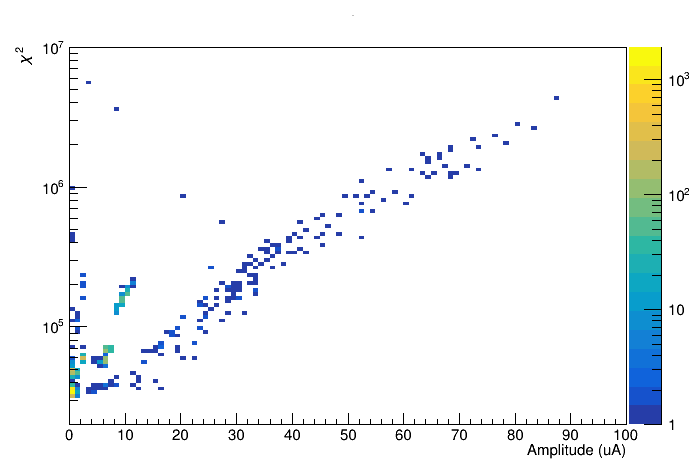

In [12]:

h_chi2_ofamp_pt[0].Draw('colz')
can.Draw()

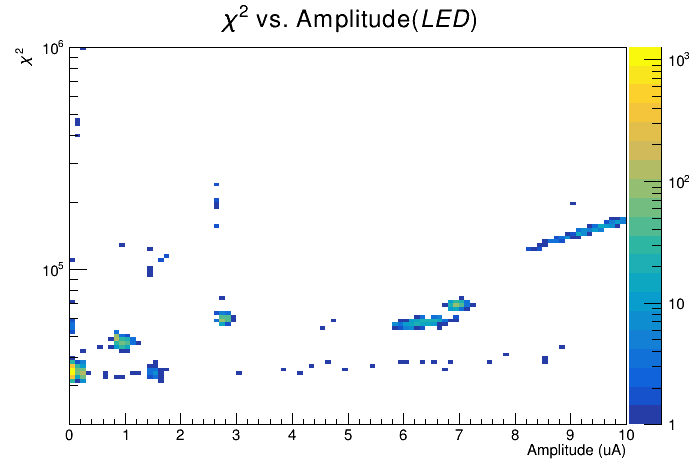

In [13]:
h_chi2_ofamp_pt_zoomed[0].Draw('colz')
can.Draw()

In [46]:
[idx for idx in range(1,2)]

[]

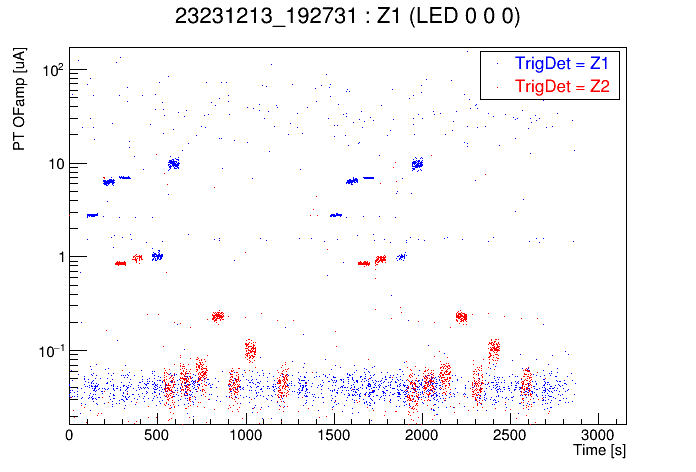

In [60]:
#gr_amp_t = rt.TGraph('gr_amp_t','gr_amp_t',0,10e3)
chan = 'PT'
key = 'LED'
det = 'Z1'
marker_color = [rt.kBlue, rt.kRed, rt.kBlack]
lname = ['TrigDet = Z1','TrigDet = Z2','TrigDet = Z3']
graphs = []
idx = 0
for i in range(1,4):
    mask = (TriggerType[idx] == 1) & (OFamps[series[key]][det][chan] > 0.) & (EventTime[idx] > 0.) & (TrigDet[idx] == i)
    if(np.sum(mask) == 0):
        continue
    t0 = EventTime[idx][mask][0]
    x = EventTime[idx][mask] - t0
    y = OFamps[series[key]][det][chan][mask]*1e6
    gr_amp_t = rt.TGraph(len(x),x,y)
    gr_amp_t.SetMarkerColor(marker_color[i-1])
    gr_amp_t.SetTitle('%s : %s (%s 0 0 0)'%(series[key],det,key) )
    gr_amp_t.GetXaxis().SetTitle('Time [s]')
    gr_amp_t.GetYaxis().SetTitle('PT OFamp [uA]')
    graphs.append(gr_amp_t)

l = rt.TLegend(0.69, 0.89, 0.89, 0.79) # x,y of top left and x,y of bottom right
#l = rt.TLegend(0.2, 0.75, 0.4, 0.85)
for i,gr in enumerate(graphs):
    ll = l.AddEntry(gr, lname[i], 'p')
    ll.SetTextColor(gr.GetMarkerColor())
    if(i==0):
        gr.GetXaxis().SetRangeUser(0,3500)
        
        gr.Draw('AP')
    else:
        gr.Draw('P same')
    
can.SetLogy()
l.Draw()
can.Draw()
# print(len(x))
# print(len(y))

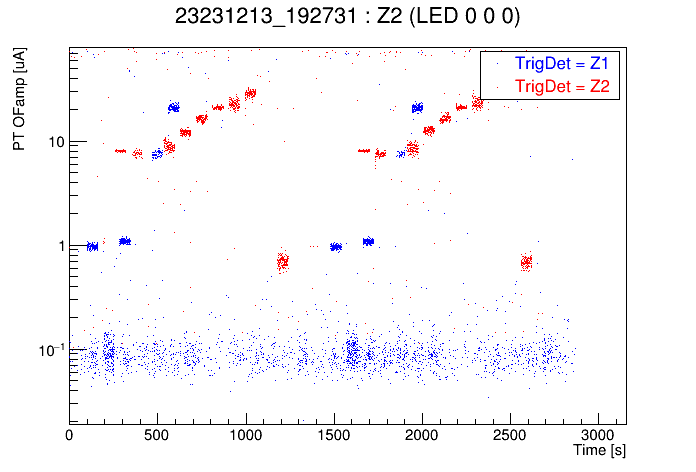

In [61]:
#gr_amp_t = rt.TGraph('gr_amp_t','gr_amp_t',0,10e3)
chan = 'PT'
key = 'LED'
det = 'Z2'
marker_color = [rt.kBlue, rt.kRed, rt.kBlack]
lname = ['TrigDet = Z1','TrigDet = Z2','TrigDet = Z3']
graphs = []
idx = 0
for i in range(1,4):
    mask = (TriggerType[idx] == 1) & (OFamps[series[key]][det][chan] > 0.) & (EventTime[idx] > 0.) & (TrigDet[idx] == i)
    if(np.sum(mask) == 0):
        continue
    t0 = EventTime[idx][mask][0]
    x = EventTime[idx][mask] - t0
    y = OFamps[series[key]][det][chan][mask]*1e6
    gr_amp_t = rt.TGraph(len(x),x,y)
    gr_amp_t.SetMarkerColor(marker_color[i-1])
    gr_amp_t.SetTitle('%s : %s (%s 0 0 0)'%(series[key],det,key) )
    gr_amp_t.GetXaxis().SetTitle('Time [s]')
    gr_amp_t.GetYaxis().SetTitle('PT OFamp [uA]')
    graphs.append(gr_amp_t)

l = rt.TLegend(0.69, 0.89, 0.89, 0.79) # x,y of top left and x,y of bottom right
#l = rt.TLegend(0.2, 0.75, 0.4, 0.85)
for i,gr in enumerate(graphs):
    ll = l.AddEntry(gr, lname[i], 'p')
    ll.SetTextColor(gr.GetMarkerColor())
    if(i==0):
        gr.GetXaxis().SetRangeUser(0,3500)
        
        gr.Draw('AP')
    else:
        gr.Draw('P same')
    
can.SetLogy()
l.Draw()
can.Draw()
# print(len(x))
# print(len(y))

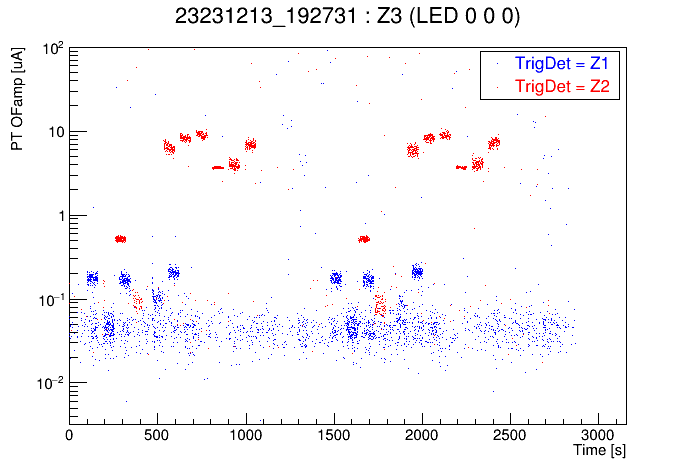

In [62]:
#gr_amp_t = rt.TGraph('gr_amp_t','gr_amp_t',0,10e3)
chan = 'PT'
key = 'LED'
det = 'Z3'
marker_color = [rt.kBlue, rt.kRed, rt.kBlack]
lname = ['TrigDet = Z1','TrigDet = Z2','TrigDet = Z3']
graphs = []
idx = 0
for i in range(1,4):
    mask = (TriggerType[idx] == 1) & (OFamps[series[key]][det][chan] > 0.) & (EventTime[idx] > 0.) & (TrigDet[idx] == i)
    if(np.sum(mask) == 0):
        continue
    t0 = EventTime[idx][mask][0]
    x = EventTime[idx][mask] - t0
    y = OFamps[series[key]][det][chan][mask]*1e6
    gr_amp_t = rt.TGraph(len(x),x,y)
    gr_amp_t.SetMarkerColor(marker_color[i-1])
    gr_amp_t.SetTitle('%s : %s (%s 0 0 0)'%(series[key],det,key) )
    gr_amp_t.GetXaxis().SetTitle('Time [s]')
    gr_amp_t.GetYaxis().SetTitle('PT OFamp [uA]')
    graphs.append(gr_amp_t)

l = rt.TLegend(0.69, 0.89, 0.89, 0.79) # x,y of top left and x,y of bottom right
#l = rt.TLegend(0.2, 0.75, 0.4, 0.85)
for i,gr in enumerate(graphs):
    ll = l.AddEntry(gr, lname[i], 'p')
    ll.SetTextColor(gr.GetMarkerColor())
    if(i==0):
        gr.GetXaxis().SetRangeUser(0,3500)
        
        gr.Draw('AP')
    else:
        gr.Draw('P same')
    
can.SetLogy()
l.Draw()
can.Draw()
# print(len(x))
# print(len(y))

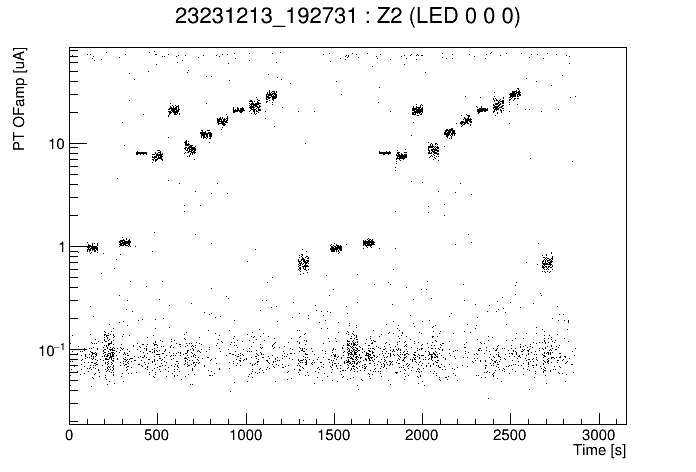

In [31]:
chan = 'PT'
key = 'LED'
det = 'Z2'
idx = 0
mask = (TriggerType[idx] == 1) & (OFamps[series[key]][det][chan] > 0.) & (EventTime[idx] > 0.)
t0 = EventTime[idx][mask][0]
#EventTime[0][mask] - t0

x = EventTime[idx][mask] - t0
y = OFamps[series[key]][det][chan][mask]*1e6
gr_amp_t = rt.TGraph(len(x),x,y)
gr_amp_t.SetTitle('%s : %s (%s 0 0 0)'%(series[key],det,key) )
gr_amp_t.GetXaxis().SetTitle('Time [s]')
gr_amp_t.GetYaxis().SetTitle('PT OFamp [uA]')
gr_amp_t.Draw('AP')
can.SetLogy()
can.Draw()

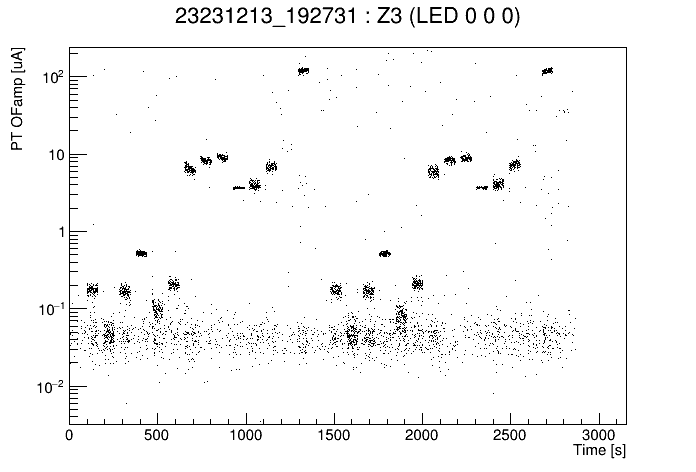

In [32]:
chan = 'PT'
key = 'LED'
det = 'Z3'
idx = 0
mask = (TriggerType[idx] == 1) & (OFamps[series[key]][det][chan] > 0.) & (EventTime[idx] > 0.)
t0 = EventTime[idx][mask][0]
#EventTime[0][mask] - t0

x = EventTime[idx][mask] - t0
y = OFamps[series[key]][det][chan][mask]*1e6
gr_amp_t = rt.TGraph(len(x),x,y)
gr_amp_t.SetTitle('%s : %s (%s 0 0 0)'%(series[key],det,key) )
gr_amp_t.GetXaxis().SetTitle('Time [s]')
gr_amp_t.GetYaxis().SetTitle('PT OFamp [uA]')
gr_amp_t.Draw('AP')
can.SetLogy()
can.Draw()

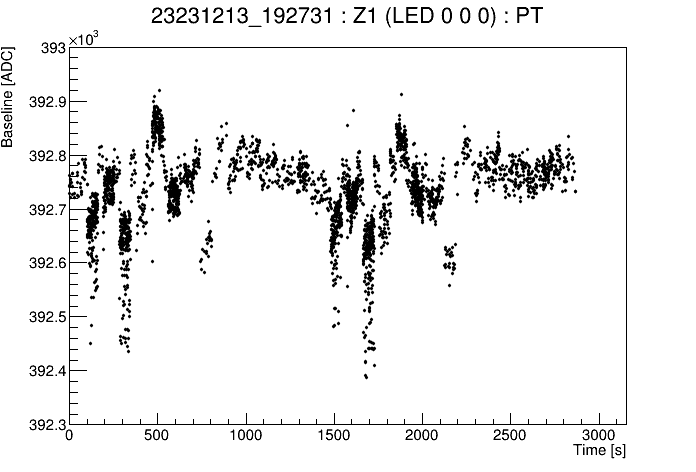

In [66]:
chan = 'PT'
key = 'LED'
det = 'Z1'
idx = 0
mask = (TriggerType[idx] == 1) & (OFamps[series[key]][det][chan] > 0.) & (EventTime[idx] > 0.) & (TrigDet[idx] == 1)
t0 = EventTime[idx][mask][0]
#EventTime[0][mask] - t0

x = EventTime[idx][mask] - t0
y = bs[series[key]][det][chan][mask]
gr_bs_t = rt.TGraph(len(x),x,y)
gr_bs_t.SetTitle('%s : %s (%s 0 0 0) : %s'%(series[key],det,key,chan) )
gr_bs_t.GetXaxis().SetTitle('Time [s]')
gr_bs_t.GetYaxis().SetTitle('Baseline [ADC]')
gr_bs_t.GetYaxis().SetRangeUser(392.3e3,393e3)
gr_bs_t.SetMarkerStyle(mstyle)
gr_bs_t.SetMarkerSize(msize)
gr_bs_t.Draw('AP')
can.SetLogy(0)
can.Draw()

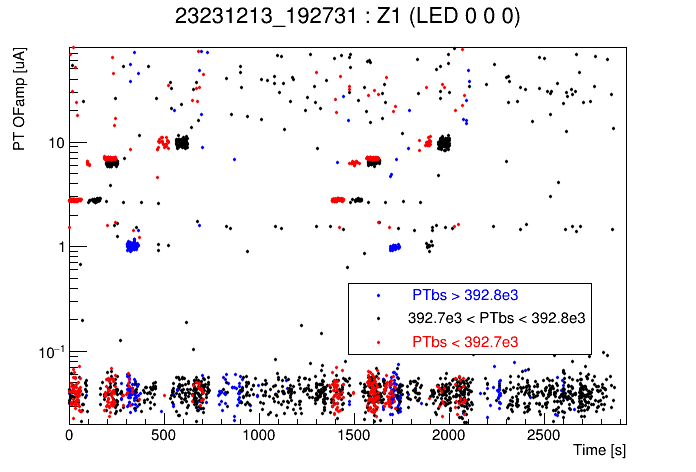

In [64]:
chan = 'PT'
key = 'LED'
det = 'Z1'
mstyle = rt.kFullCircle
msize = 0.4
idx = 0
mask = (TriggerType[idx] == 1) & (OFamps[series[key]][det][chan] > 0.) & (EventTime[idx] > 0.) & (TrigDet[idx] == 1) & (bs[series[key]][det][chan] > 392.8e3)
t0 = EventTime[idx][mask][0]
#EventTime[0][mask] - t0

x = EventTime[idx][mask] - t0
y = OFamps[series[key]][det][chan][mask]*1e6
gr_amp_t_1 = rt.TGraph(len(x),x,y)
gr_amp_t_1.SetTitle('%s : %s (%s 0 0 0)'%(series[key],det,key) )
gr_amp_t_1.GetXaxis().SetTitle('Time [s]')
gr_amp_t_1.GetYaxis().SetTitle('PT OFamp [uA]')
gr_amp_t_1.SetMarkerColor(rt.kBlue)
gr_amp_t_1.SetMarkerStyle(mstyle)
gr_amp_t_1.SetMarkerSize(msize)

mask = (TriggerType[idx] == 1) & (OFamps[series[key]][det][chan] > 0.) & (EventTime[idx] > 0.) & (TrigDet[idx] == 1) & (bs[series[key]][det][chan] < 392.8e3) & (bs[series[key]][det][chan] > 392.7e3)
t0 = EventTime[idx][mask][0]
#EventTime[0][mask] - t0

x = EventTime[idx][mask] - t0
y = OFamps[series[key]][det][chan][mask]*1e6
gr_amp_t_2 = rt.TGraph(len(x),x,y)
gr_amp_t_2.SetTitle('%s : %s (%s 0 0 0)'%(series[key],det,key) )
gr_amp_t_2.GetXaxis().SetTitle('Time [s]')
gr_amp_t_2.GetYaxis().SetTitle('PT OFamp [uA]')
gr_amp_t_2.SetMarkerColor(rt.kBlack)
gr_amp_t_2.SetMarkerStyle(mstyle)
gr_amp_t_2.SetMarkerSize(msize)

mask = (TriggerType[idx] == 1) & (OFamps[series[key]][det][chan] > 0.) & (EventTime[idx] > 0.) & (TrigDet[idx] == 1) & (bs[series[key]][det][chan] < 392.7e3)
t0 = EventTime[idx][mask][0]
#EventTime[0][mask] - t0

x = EventTime[idx][mask] - t0
y = OFamps[series[key]][det][chan][mask]*1e6
gr_amp_t_3 = rt.TGraph(len(x),x,y)
gr_amp_t_3.SetTitle('%s : %s (%s 0 0 0)'%(series[key],det,key) )
gr_amp_t_3.GetXaxis().SetTitle('Time [s]')
gr_amp_t_3.GetYaxis().SetTitle('PT OFamp [uA]')
gr_amp_t_3.SetMarkerColor(rt.kRed)
gr_amp_t_3.SetMarkerStyle(mstyle)
gr_amp_t_3.SetMarkerSize(msize)



gr_amp_t_1.Draw('AP')
gr_amp_t_2.Draw('P same')
gr_amp_t_3.Draw('P same')

#l = rt.TLegend(0.5, 0.89, 0.85, 0.75)
l = rt.TLegend(0.5, 0.4, 0.85, 0.25)
l.SetTextSize(0.035)

l1 = l.AddEntry(gr_amp_t_1,' PTbs > 392.8e3','P')
l1.SetTextColor(gr_amp_t_1.GetMarkerColor())
l2 = l.AddEntry(gr_amp_t_2,'392.7e3 < PTbs < 392.8e3','P')
l2.SetTextColor(gr_amp_t_2.GetMarkerColor())
l3 = l.AddEntry(gr_amp_t_3,' PTbs < 392.7e3','P')
l3.SetTextColor(gr_amp_t_3.GetMarkerColor())
can.SetLogy()
l.Draw()
can.Draw()

13391
13391


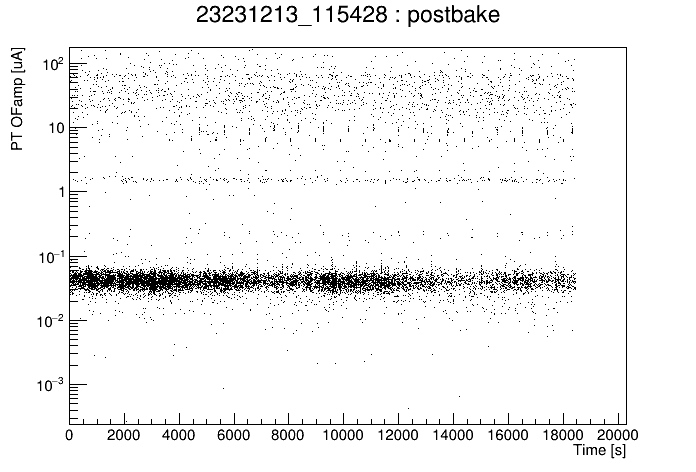

In [115]:
#gr_amp_t = rt.TGraph('gr_amp_t','gr_amp_t',0,10e3)
chan = 'PT'
key = 'postbake'
idx = 1
mask = (TriggerType[idx] == 1) & (OFamps[series[key]][chan] > 0.) & (EventTime[idx] > 0.)
t0 = EventTime[idx][mask][0]
#EventTime[0][mask] - t0

x = EventTime[idx][mask] - t0
y = OFamps[series[key]][chan][mask]*1e6
gr_amp_t = rt.TGraph(len(x),x,y)
gr_amp_t.SetTitle(series[key]+ ' : ' +key )
gr_amp_t.GetXaxis().SetTitle('Time [s]')
gr_amp_t.GetYaxis().SetTitle('PT OFamp [uA]')
gr_amp_t.Draw('AP')
can.SetLogy()
can.Draw()
print(len(x))
print(len(y))

In [66]:
c = 'PT'
dat = 'prebake'
mask = (TriggerType[0] == 1) & (OFamps[series[dat]][c] > 0.)
#h_chi2_ofamp_pt = rt.TH2F('h_chi2_ofamp_pt','\chi^2 \mbox{ vs. Amplitude};Amplitude (A);\chi^2',100,0, 2.5e-4,100,np.logspace(4.3, 8.4, 101))
h_chi2_ofamp_pt = rt.TH2F('h_chi2_ofamp_pt','\chi^2 \mbox{ vs. Amplitude} (%s);Amplitude (uA);\chi^2'%(dat),100,0, 10,100,np.logspace(4.3, 6, 101))
h_ofamp_pt = rt.TH1F('h_ofamp_pt','%s (chi2 < 5e4 & 1 < ofamp < 2 )'%(dat),200,0.5,2.5)
h_ofamp_pt.GetXaxis().SetTitle('PT OFAmps [uA]')
x = OFamps[series[dat]][c][mask]*1e6
y = OFchiq[series[dat]][c][mask]
for i in range(len(OFchiq[series[dat]][c][mask])):
    h_chi2_ofamp_pt.Fill(x[i],y[i])
    if((x[i] < 2) and (x[i] > 1) and (y[i] < 5e4)):
        h_ofamp_pt.Fill(x[i])
print('Done...')

Done...


<>:5: DeprecationWarning: invalid escape sequence \c
<>:5: DeprecationWarning: invalid escape sequence \c
<>:5: DeprecationWarning: invalid escape sequence \c
<ipython-input-66-e9035d618231>:5: DeprecationWarning: invalid escape sequence \c
  h_chi2_ofamp_pt = rt.TH2F('h_chi2_ofamp_pt','\chi^2 \mbox{ vs. Amplitude} (%s);Amplitude (uA);\chi^2'%(dat),100,0, 10,100,np.logspace(4.3, 6, 101))


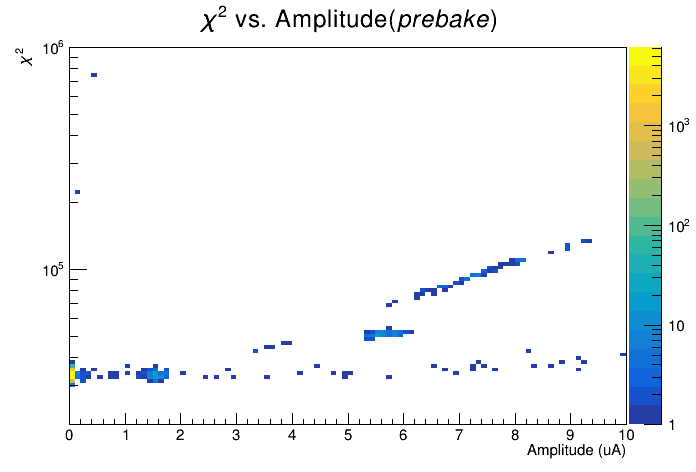

In [68]:
can = rt.TCanvas()
can.SetLogy()
rt.gStyle.SetOptStat(0)
can.SetLogz()
h_chi2_ofamp_pt.Draw('colz')
can.Draw()

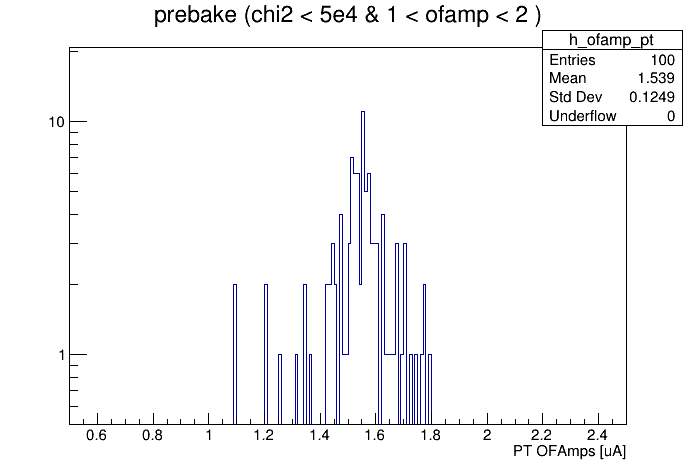

In [69]:
h_ofamp_pt.Draw()
rt.gStyle.SetOptStat(11111)
can.Draw()

In [27]:
h_ofamp_pt.GetEntries()

107.0

In [29]:
x[0:10]

array([2.87639633e-08, 4.78958130e-08, 6.06340127e-08, 3.29056191e-08,
       5.75420287e-08, 5.72963998e-08, 4.56184162e-08, 3.60516766e-08,
       4.02845714e-08, 5.95859903e-08])

In [13]:
#len(OFamps[series[dat]][c][mask])
len(OFchiq[series[dat]][c][mask])

12839

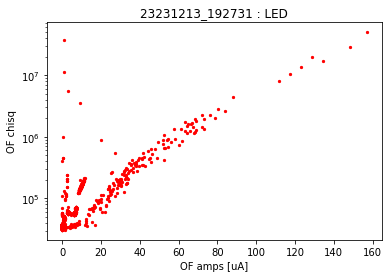

In [14]:
# Event selection
#Selecting saturated events
c = 'PT'
dat = 'LED'
mask = (TriggerType[0] == 1) & (OFamps[series[dat]][c] > 0.)
plt.scatter(OFamps[series[dat]][c][mask]*1e6,OFchiq[series[dat]][c][mask],s=5 ,color='r')

# plt.vlines(1.05,1e4,2e5)
# plt.vlines(2.3,1e4,2e5)
# plt.hlines(2e5,1.05,2.3)

# plt.xlim(0,10)
# plt.ylim(1e4,1e8)
plt.yscale("log")
plt.xlabel("OF amps [uA]")
plt.ylabel("OF chisq")
plt.title(series[dat]+ ' : ' + dat)
#plt.savefig("./plots/reverse_cal/OF_chi2_%s_scatter.png"%(c))
plt.show()

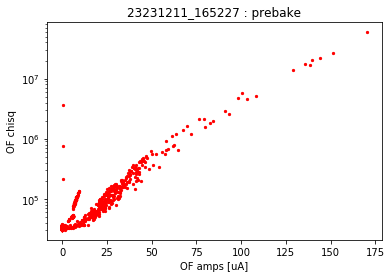

In [13]:
# Event selection
#Selecting saturated events
c = 'PT'
dat = 'prebake'
mask = (TriggerType[0] == 1) & (OFamps[series[dat]][c] > 0.)
plt.scatter(OFamps[series[dat]][c][mask]*1e6,OFchiq[series[dat]][c][mask],s=5 ,color='r')

# plt.vlines(1.05,1e4,2e5)
# plt.vlines(2.3,1e4,2e5)
# plt.hlines(2e5,1.05,2.3)

# plt.xlim(0,10)
# plt.ylim(1e4,1e8)
plt.yscale("log")
plt.xlabel("OF amps [uA]")
plt.ylabel("OF chisq")
plt.title(series[dat]+ ' : ' + dat)
#plt.savefig("./plots/reverse_cal/OF_chi2_%s_scatter.png"%(c))
plt.show()


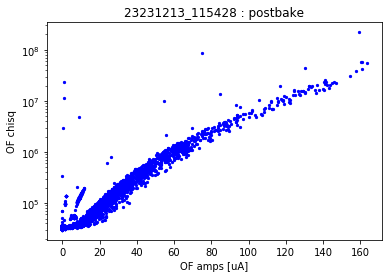

In [14]:
c = 'PT'
dat = 'postbake'
mask = (TriggerType[1] == 1) & (OFamps[series[dat]][c] > 0.)
plt.scatter(OFamps[series[dat]][c][mask]*1e6,OFchiq[series[dat]][c][mask],s=5 ,color='b')

# plt.vlines(1.05,1e4,2e5)
# plt.vlines(2.3,1e4,2e5)
# plt.hlines(2e5,1.05,2.3)

#plt.xlim(0,10)
#plt.ylim(1e4,1e8)
plt.yscale("log")
plt.xlabel("OF amps [uA]")
plt.ylabel("OF chisq")
plt.title(series[dat]+ ' : ' + dat)
#plt.savefig("./plots/reverse_cal/OF_chi2_%s_scatter.png"%(c))
plt.show()

In [82]:
c = 'PT'
dat = 'postbake'
mask = (TriggerType[1] == 1) & (OFamps[series[dat]][c] > 0.)
#h_chi2_ofamp_pt = rt.TH2F('h_chi2_ofamp_pt','\chi^2 \mbox{ vs. Amplitude};Amplitude (A);\chi^2',100,0, 2.5e-4,100,np.logspace(4.3, 8.4, 101))
h_chi2_ofamp_pt_post = rt.TH2F('h_chi2_ofamp_pt_post','\chi^2 \mbox{ vs. Amplitude} (%s);Amplitude (uA);\chi^2'%(dat),100,0, 10,100,np.logspace(4, 7, 101))
h_ofamp_pt_post = rt.TH1F('h_ofamp_pt_post','%s (chi2 < 5e4 & 1 < ofamp < 2 )'%(dat),200,0.5,2.5)
h_ofamp_pt_post.GetXaxis().SetTitle('PT OFAmps [uA]')
x = OFamps[series[dat]][c][mask]*1e6
y = OFchiq[series[dat]][c][mask]
for i in range(len(OFchiq[series[dat]][c][mask])):
    h_chi2_ofamp_pt_post.Fill(x[i],y[i])
    if((x[i] < 2) and (x[i] > 1) and (y[i] < 5e4)):
        h_ofamp_pt_post.Fill(x[i])
print('Done...')

Done...


<>:5: DeprecationWarning: invalid escape sequence \c
<>:5: DeprecationWarning: invalid escape sequence \c
<>:5: DeprecationWarning: invalid escape sequence \c
<ipython-input-82-929d0b625672>:5: DeprecationWarning: invalid escape sequence \c
  h_chi2_ofamp_pt_post = rt.TH2F('h_chi2_ofamp_pt_post','\chi^2 \mbox{ vs. Amplitude} (%s);Amplitude (uA);\chi^2'%(dat),100,0, 10,100,np.logspace(4, 7, 101))
Warning in <TROOT::Append>: Replacing existing TH1: h_chi2_ofamp_pt_post (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_ofamp_pt_post (Potential memory leak).


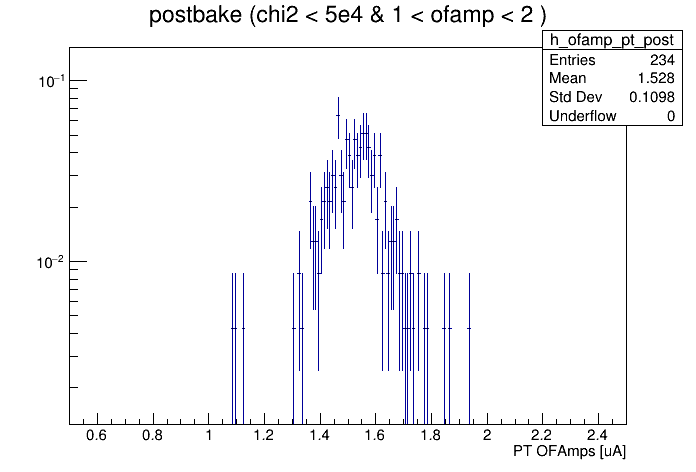

In [83]:
temp = h_ofamp_pt_post.Clone()
temp.Scale(1.0/temp.Integral())
temp.Draw()
can.Draw()

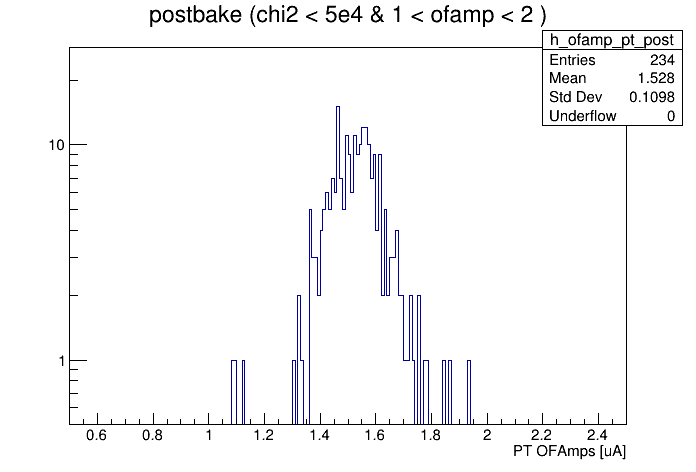

In [84]:
h_ofamp_pt_post.Draw()
can.Draw()

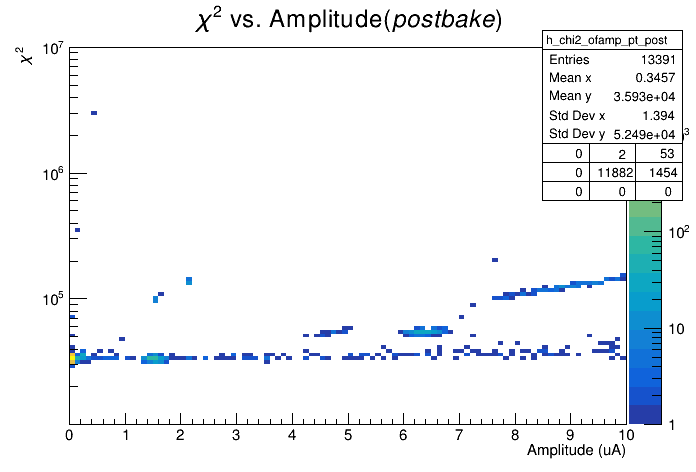

In [51]:
can = rt.TCanvas()
can.SetLogy()
#rt.gStyle.SetOptStat(0)
can.SetLogz()
h_chi2_ofamp_pt_post.Draw('colz')
can.Draw()

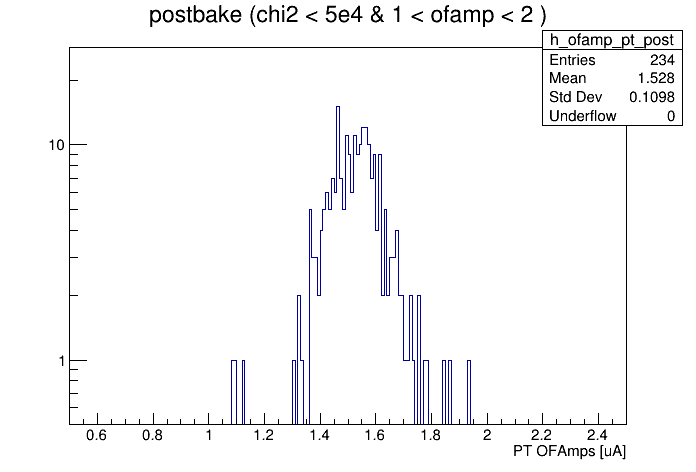

In [71]:
h_ofamp_pt_post.Draw()
can.Draw()

In [72]:
h_ofamp_pt.Scale(1./h_ofamp_pt.Integral())
h_ofamp_pt.Rebin(2)
h_ofamp_pt.SetLineColor(rt.kBlue)
h_ofamp_pt.SetLineStyle(1)
h_ofamp_pt.SetLineWidth(2)
h_ofamp_pt.SetTitle("")
h_ofamp_pt.GetYaxis().SetTitle('Normalized')

h_ofamp_pt_post.Scale(1./h_ofamp_pt_post.Integral())
h_ofamp_pt_post.Rebin(2)
h_ofamp_pt_post.SetLineColor(rt.kRed)
h_ofamp_pt_post.SetLineStyle(1)
h_ofamp_pt_post.SetLineWidth(2)
h_ofamp_pt_post.SetTitle("")
h_ofamp_pt_post.GetYaxis().SetTitle('Normalized')


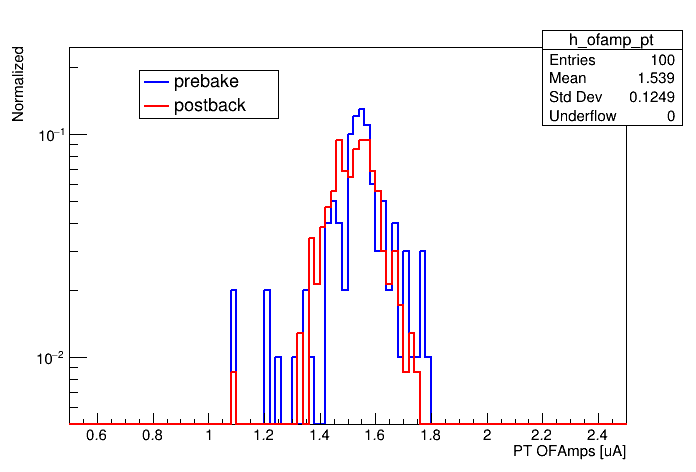

In [74]:
h_ofamp_pt.Draw('hist')
h_ofamp_pt_post.Draw('hist same')

l = rt.TLegend(0.2, 0.75, 0.4, 0.85) # x,y of top left and x,y of bottom right
l.AddEntry(h_ofamp_pt, "prebake", "l") # "l" to say it's just a line, no points
l.AddEntry(h_ofamp_pt_post, "postback", "l")

l.Draw()
can.Draw()

In [10]:
#Get RQs from processed files
# chan=['PBS2']
# series=['23210325_211520','23210326_012655','23210326_130758','23210327_010110','23210327_190020','23210328_051029','23210328_142945','23210329_021134','23210329_114716']
chan=['PT','PAS1','PBS1','PCS1','PDS1','PES1','PFS1','PAS2','PBS2','PCS2','PDS2','PES2','PFS2']
#series=['23231024_231640']
TriggerTime=[]
TriggerType=[]
EventNumber=[]
TrigDet=[]
TriggerMask=[]
EventTime=[]
for i in range(len(series)):
    TriggerTime.append(eventTree[i].array("TriggerTime"))
    TriggerType.append(eventTree[i].array("TriggerType"))
    EventNumber.append(eventTree[i].array("EventNumber"))
    TrigDet.append(eventTree[i].array("TriggerDetectorNum"))
    TriggerMask.append(eventTree[i].array("TriggerMask"))
    EventTime.append(eventTree[i].array("EventTime"))

In [6]:
TESs = {
    'PAS1' : 'TES5',
    'PBS1' : 'TES3',
    'PCS1' : 'TES1',
    'PDS1' : 'TES2',
    'PES1' : 'TES4',
    'PFS1' : 'TES0',
    'PAS2' : 'TES11',
    'PBS2' : 'TES8',
    'PCS2' : 'TES7',
    'PDS2' : 'TES10',
    'PES2' : 'TES9',
    'PFS2' : 'TES6',   
}
Rn = {
    'TES0' : 68.45e-3,
    'TES1' : 69.35e-3,
    'TES2' : 71.96e-3,
    'TES3' : 75.48e-3,
    'TES4' : 71.67e-3,
    'TES5' : 79.84e-3,
    'TES6' : 67.05e-3,
    'TES7' : 67.75e-3,
    'TES8' : 72.85e-3,
    'TES9' : 69.4e-3,
    'TES10' : 73.43e-3,
    'TES11' : 78.69e-3
}
Rp = {
    'TES0' : 1.45e-3,
    'TES1' : 1.02e-3,
    'TES2' : 0.66e-3,
    'TES3' : 0.7e-3,
    'TES4' : 1.17e-3,
    'TES5' : 1.05e-3,
    'TES6' : 1.0e-3,
    'TES7' : 1.15e-3,
    'TES8' : 0.74e-3,
    'TES9' : 0.79e-3,
    'TES10' : 0.74e-3,
    'TES11' : 0.9e-3
}
Rshunt = 5.0e-3 # shunt resistance
Rl = {}
for key in Rp.keys():
    Rl[key] = Rp[key] + Rn[key]

print('TES : Rp [mOhm] : Rn [mOhm] : Rl [mOhm]')
for key in Rp.keys():
    print('%s : %0.2f : %0.2f : %0.2f'%(key, Rp[key]*1e3, Rn[key]*1e3, Rl[key]*1e3))
Rfb = 5000.0 # feedback resistance
ADCperVolt = 65536.0/8.0 # the number of ADC bins per V for the readout
LoopRatio = 2.4 # SQUID turn ratio 
low_pass_filter = False
high_cutoff, fs, order = 100000, 625000, 2
rawfilepath='/sdf/group/supercdms/data/CDMS/CUTE/R35/Raw/'

TES : Rp [mOhm] : Rn [mOhm] : Rl [mOhm]
TES0 : 1.45 : 68.45 : 69.90
TES1 : 1.02 : 69.35 : 70.37
TES2 : 0.66 : 71.96 : 72.62
TES3 : 0.70 : 75.48 : 76.18
TES4 : 1.17 : 71.67 : 72.84
TES5 : 1.05 : 79.84 : 80.89
TES6 : 1.00 : 67.05 : 68.05
TES7 : 1.15 : 67.75 : 68.90
TES8 : 0.74 : 72.85 : 73.59
TES9 : 0.79 : 69.40 : 70.19
TES10 : 0.74 : 73.43 : 74.17
TES11 : 0.90 : 78.69 : 79.59


In [12]:
#Load detector settings
dsettings={}
for i in range(len(series)):
    dsettings[series[i]]=cdms.rawio.IO.getDetectorSettings(rawfilepath,series[i])

The file is: /sdf/group/supercdms/data/CDMS/CUTE/R35/Raw//23231024_231640/23231024_231640_F0001.mid.gz

Opened raw midas file: /sdf/group/supercdms/data/CDMS/CUTE/R35/Raw//23231024_231640/23231024_231640_F0001.mid.gz
INFO in DetectorConfigData: list of available detectors = 1, 2, 3, 4, 5, 6


In [13]:
#Get QET bias
QETbias={}
det='Z1'
for c in chan:
    if(c == 'PT'):
        continue
    QETbias[c]=dsettings[series[0]][det][c]['qetBias']
    print('QETbias for %s = %f'%(c, QETbias[c]))
Vbias = {}
for c in chan:
    if(c == 'PT'):
        continue
    Vbias[c] = QETbias[c]*Rshunt
    print('Vbias for %s = %0.3f uV'%(c, Vbias[c]*1e6))

QETbias for PAS1 = 0.000225
QETbias for PBS1 = 0.000219
QETbias for PCS1 = 0.000221
QETbias for PDS1 = 0.000209
QETbias for PES1 = 0.000217
QETbias for PFS1 = 0.000219
QETbias for PAS2 = 0.000227
QETbias for PBS2 = 0.000227
QETbias for PCS2 = 0.000221
QETbias for PDS2 = 0.000219
QETbias for PES2 = 0.000213
QETbias for PFS2 = 0.000212
Vbias for PAS1 = 1.125 uV
Vbias for PBS1 = 1.095 uV
Vbias for PCS1 = 1.105 uV
Vbias for PDS1 = 1.045 uV
Vbias for PES1 = 1.085 uV
Vbias for PFS1 = 1.095 uV
Vbias for PAS2 = 1.135 uV
Vbias for PBS2 = 1.135 uV
Vbias for PCS2 = 1.105 uV
Vbias for PDS2 = 1.095 uV
Vbias for PES2 = 1.065 uV
Vbias for PFS2 = 1.060 uV


In [14]:
# Dc offset as measured from IbIs
DCoffset={}
of = [9.8e-6, 13.0e-6, 13.0e-6, 13.5e-6, 12.5e-6, 13.3e-6, 10.0e-6, 10.4e-6, 13.0e-6, 12.1e-6, 13.2e-6, 14.3e-6]
for i,c in enumerate(chan):
    if(c == 'PT'):
        continue
    DCoffset[c]=of[i-1]
    print('DCOffset for %s = %f uA'%(c, DCoffset[c]*1e6))

DCOffset for PAS1 = 9.800000 uA
DCOffset for PBS1 = 13.000000 uA
DCOffset for PCS1 = 13.000000 uA
DCOffset for PDS1 = 13.500000 uA
DCOffset for PES1 = 12.500000 uA
DCOffset for PFS1 = 13.300000 uA
DCOffset for PAS2 = 10.000000 uA
DCOffset for PBS2 = 10.400000 uA
DCOffset for PCS2 = 13.000000 uA
DCOffset for PDS2 = 12.100000 uA
DCOffset for PES2 = 13.200000 uA
DCOffset for PFS2 = 14.300000 uA


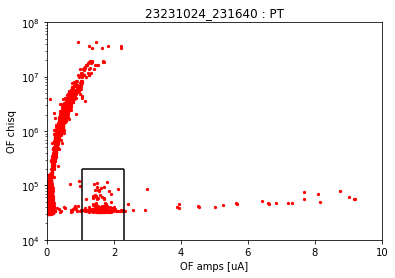

In [44]:
# Event selection
#Selecting saturated events
c = 'PT'

mask = (TriggerType[0] == 1) & (OFamps[series[0]][c] > 0.)
plt.scatter(OFamps[series[0]][c][mask]*1e6,OFchiq[series[0]][c][mask],s=5 ,color='r')
plt.vlines(1.05,1e4,2e5)
plt.vlines(2.3,1e4,2e5)
plt.hlines(2e5,1.05,2.3)
#     plt.hlines(3e8,0,1.1e-5)
#plt.xlim(0,20e-6)
plt.xlim(0,10)
plt.ylim(1e4,1e8)
plt.yscale("log")
plt.xlabel("OF amps [uA]")
plt.ylabel("OF chisq")
plt.title(series[0]+ ' : ' + c)
plt.savefig("./plots/reverse_cal/OF_chi2_%s_scatter.png"%(c))
plt.show()


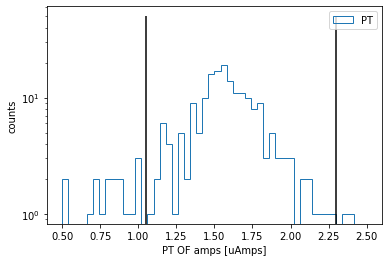

In [40]:
c = 'PT'
#mask = (TriggerType[0] == 1) & (OFamps[series[0]][c] > 2.5e-6) & (OFchiq[series[0]][c] < 15e6)
mask = (TriggerType[0] == 1) & (OFamps[series[0]][c] > 0.) & (OFchiq[series[0]][c] < 2e5)
plt.hist(OFamps[series[0]][c][mask]*1e6,bins=50,range=[0.5,2.5],histtype='step',label="PT")
plt.vlines(1.05,0,0.5e2)
plt.vlines(2.3,0,0.5e2)
plt.xlabel('PT OF amps [uAmps]')
plt.ylabel('counts')
plt.yscale("log")
plt.legend(loc='best')
plt.savefig("./plots/reverse_cal/OF_%s_hist.png"%(c))

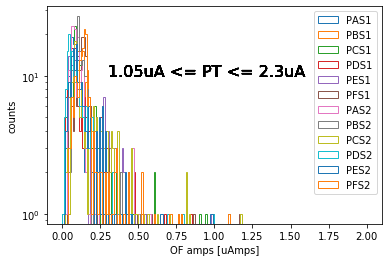

In [42]:

#mask = (TriggerType[0] == 1) & (OFamps[series[0]]['PT'] > 2.5e-6) & (OFchiq[series[0]]['PT'] < 15e6) # Ruchi's base cleaning cut
mask = (TriggerType[0] == 1) & (OFamps[series[0]][c] > 0.) & (OFchiq[series[0]][c] < 2e5)
cut = mask & (OFamps[series[0]]['PT'] >= 1.05e-6) & (OFamps[series[0]]['PT'] <= 2.3e-6)
for c in chan:
    if(c=='PT'):
        continue
    plt.hist(OFamps[series[0]][c][cut]*1e6,bins=200,range=[0,2.0],histtype='step',label="%s"%(c))
    plt.text(0.3,10,'1.05uA <= PT <= 2.3uA',fontsize=16)
    #plt.vlines(18,0,1e3)
    #plt.vlines(22,0,1e3)
plt.xlabel('OF amps [uAmps]')
plt.ylabel('counts')
plt.yscale("log")
plt.legend(loc='best')
plt.savefig('./plots/reverse_cal/OF_channels_with_PT_cut.png')

In [18]:

mask = (TriggerType[0] == 1) & (OFamps[series[0]][c] > 0.) & (OFchiq[series[0]][c] < 2e5) #new mask
cut = mask & (OFamps[series[0]]['PT'] >= 1.03e-6) & (OFamps[series[0]]['PT'] <= 2.3e-6)
data = {}
raw_data = {}
det = 'Z1'
event_number = {}

In [20]:
#c = 'PAS2'

for c in chan:
    if(c=='PT'):
        continue
    if os.path.exists('./rawdata/PT_1p05uA_2p3uA/%s_%s_selected_events.pkl'%(series[0],c)):
        raw_data[c] = pkl.load(open('./rawdata/PT_1p05uA_2p3uA/%s_%s_selected_events.pkl'%(series[0],c), "rb"))
        print('pkl file loaded for %s'%(c))
    else:
        print('No pickle file available. Loading traces... ')
        event_number[c] = EventNumber[0][cut]
        raw_data[c] = cdms.rawio.IO.getRawEvents(rawfilepath,'/'+series[0],outputFormat = 2, eventNumbers=(event_number[c]).astype(int).tolist(), 
                                               channelList=[c])
        pkl.dump(raw_data[c], open('./rawdata/PT_1p05uA_2p3uA/%s_%s_selected_events.pkl'%(series[0],c), "wb"))
        print('pkl file loaded for %s'%(c))

print('Raw traces [ADC] loaded...')
print('Now converting into amps...')
for c in chan:
    if(c=='PT'):
        continue
    temp = []
    for i in range(len(raw_data[c])):
        DriverGain = dsettings[series[0]][det][c]['driverGain']*4.0 #Apply Driver Gain Correction
        conv2Amps = 1/(Rfb*DriverGain*LoopRatio*ADCperVolt) #Convert detector parameters to amplitude for trace
        temp.append(((raw_data[c][i])[det][c])*conv2Amps)
    data[c] = temp

print('Traces coverted to Amps for channel...')



/cvmfs/sft.cern.ch/lcg/views/LCG_98py3cu10/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/ipykernel_launcher.py:7: ResourceWarning: unclosed file <_io.BufferedReader name='./rawdata/PT_1p05uA_2p3uA/23231024_231640_PAS1_selected_events.pkl'>
  import sys


pkl file loaded for PAS1


/cvmfs/sft.cern.ch/lcg/views/LCG_98py3cu10/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/ipykernel_launcher.py:7: ResourceWarning: unclosed file <_io.BufferedReader name='./rawdata/PT_1p05uA_2p3uA/23231024_231640_PBS1_selected_events.pkl'>
  import sys


pkl file loaded for PBS1


/cvmfs/sft.cern.ch/lcg/views/LCG_98py3cu10/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/ipykernel_launcher.py:7: ResourceWarning: unclosed file <_io.BufferedReader name='./rawdata/PT_1p05uA_2p3uA/23231024_231640_PCS1_selected_events.pkl'>
  import sys


pkl file loaded for PCS1


/cvmfs/sft.cern.ch/lcg/views/LCG_98py3cu10/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/ipykernel_launcher.py:7: ResourceWarning: unclosed file <_io.BufferedReader name='./rawdata/PT_1p05uA_2p3uA/23231024_231640_PDS1_selected_events.pkl'>
  import sys


pkl file loaded for PDS1


/cvmfs/sft.cern.ch/lcg/views/LCG_98py3cu10/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/ipykernel_launcher.py:7: ResourceWarning: unclosed file <_io.BufferedReader name='./rawdata/PT_1p05uA_2p3uA/23231024_231640_PES1_selected_events.pkl'>
  import sys


pkl file loaded for PES1


/cvmfs/sft.cern.ch/lcg/views/LCG_98py3cu10/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/ipykernel_launcher.py:7: ResourceWarning: unclosed file <_io.BufferedReader name='./rawdata/PT_1p05uA_2p3uA/23231024_231640_PFS1_selected_events.pkl'>
  import sys


pkl file loaded for PFS1


/cvmfs/sft.cern.ch/lcg/views/LCG_98py3cu10/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/ipykernel_launcher.py:7: ResourceWarning: unclosed file <_io.BufferedReader name='./rawdata/PT_1p05uA_2p3uA/23231024_231640_PAS2_selected_events.pkl'>
  import sys


pkl file loaded for PAS2


/cvmfs/sft.cern.ch/lcg/views/LCG_98py3cu10/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/ipykernel_launcher.py:7: ResourceWarning: unclosed file <_io.BufferedReader name='./rawdata/PT_1p05uA_2p3uA/23231024_231640_PBS2_selected_events.pkl'>
  import sys


pkl file loaded for PBS2


/cvmfs/sft.cern.ch/lcg/views/LCG_98py3cu10/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/ipykernel_launcher.py:7: ResourceWarning: unclosed file <_io.BufferedReader name='./rawdata/PT_1p05uA_2p3uA/23231024_231640_PCS2_selected_events.pkl'>
  import sys


pkl file loaded for PCS2


/cvmfs/sft.cern.ch/lcg/views/LCG_98py3cu10/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/ipykernel_launcher.py:7: ResourceWarning: unclosed file <_io.BufferedReader name='./rawdata/PT_1p05uA_2p3uA/23231024_231640_PDS2_selected_events.pkl'>
  import sys


pkl file loaded for PDS2


/cvmfs/sft.cern.ch/lcg/views/LCG_98py3cu10/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/ipykernel_launcher.py:7: ResourceWarning: unclosed file <_io.BufferedReader name='./rawdata/PT_1p05uA_2p3uA/23231024_231640_PES2_selected_events.pkl'>
  import sys


pkl file loaded for PES2


/cvmfs/sft.cern.ch/lcg/views/LCG_98py3cu10/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/ipykernel_launcher.py:7: ResourceWarning: unclosed file <_io.BufferedReader name='./rawdata/PT_1p05uA_2p3uA/23231024_231640_PFS2_selected_events.pkl'>
  import sys


pkl file loaded for PFS2
Raw traces [ADC] loaded...
Now converting into amps...
Traces coverted to Amps for channel...


In [21]:
save = True

for c in chan:
    if(c=='PT'):
        continue
    plt.figure()
    for j in np.arange(len(data[c])):

        plt.plot(data[c][j])
        


        #plt.show()
    #plt.text(0,41.8e-6,'standard conversion',fontsize=12)
    #plt.show()
    plt.grid(b=True,which='both',axis='both')
    plt.xlabel('TimeBins')
    plt.ylabel('Current (A)')
    plt.title('%s_selected'%(c))
    if(save):
        savename='./plots/reverse_cal/selected_events/trace_%s_combined.png'%(c)
        plt.savefig(savename)
        print(savename)
    plt.close()
    #break
#     if(j ==2):
#         break

./plots/reverse_cal/selected_events/trace_PAS1_combined.png
./plots/reverse_cal/selected_events/trace_PBS1_combined.png
./plots/reverse_cal/selected_events/trace_PCS1_combined.png
./plots/reverse_cal/selected_events/trace_PDS1_combined.png
./plots/reverse_cal/selected_events/trace_PES1_combined.png
./plots/reverse_cal/selected_events/trace_PFS1_combined.png
./plots/reverse_cal/selected_events/trace_PAS2_combined.png
./plots/reverse_cal/selected_events/trace_PBS2_combined.png
./plots/reverse_cal/selected_events/trace_PCS2_combined.png
./plots/reverse_cal/selected_events/trace_PDS2_combined.png
./plots/reverse_cal/selected_events/trace_PES2_combined.png
./plots/reverse_cal/selected_events/trace_PFS2_combined.png


In [22]:
I0 = {
    'PAS1' : -24.0e-6,
    'PBS1' : -25.0e-6,
    'PCS1' : -27.5e-6,
    'PDS1' : -25.0e-6,
    'PES1' : -26.0e-6,
    'PFS1' : -27.0e-6,
    'PAS2' : -25.0e-6,
    'PBS2' : -26.5e-6,
    'PCS2' : -28.0e-6,
    'PDS2' : -26.0e-6,
    'PES2' : -27.0e-6,
    'PFS2' : -27.2e-6
}

In [23]:
converted_trace={}
for c in chan:
    if(c == 'PT'):
        continue
    temp=[]
    for i in np.arange(len(data[c])):
        temp.append((data[c][i]-DCoffset[c])*(Vbias[c]-2*I0[c]*Rl[TESs[c]]) + (Rl[TESs[c]]*(data[c][i]-DCoffset[c])**2))
        #temp.append((data[c][i]-DCoffset[c])*(Vbias[c]) + (Rl[TESs[c]]*(data[c][i]-DCoffset[c])**2))
        #temp.append(((data[c][i]-DCoffset[c])*Vbias[c])+(Rl[TESs[c]]*(data[c][i]-DCoffset[c])**2))
        #temp.append(((data[c][i]-DCoffset[c])*QETbias[c]*Rshunt)+(Rl*(data_Al[s][i]-DCoffset[s])**2))
    converted_trace[c]=temp
    print('Trace converted for channel = ',c)

Trace converted for channel =  PAS1
Trace converted for channel =  PBS1
Trace converted for channel =  PCS1
Trace converted for channel =  PDS1
Trace converted for channel =  PES1
Trace converted for channel =  PFS1
Trace converted for channel =  PAS2
Trace converted for channel =  PBS2
Trace converted for channel =  PCS2
Trace converted for channel =  PDS2
Trace converted for channel =  PES2
Trace converted for channel =  PFS2


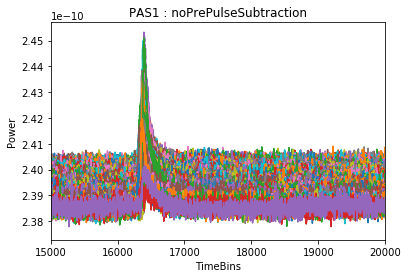

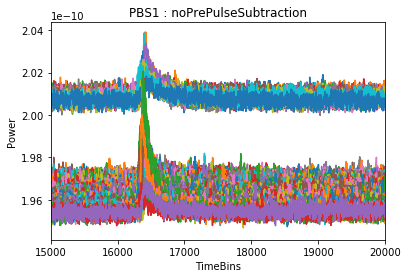

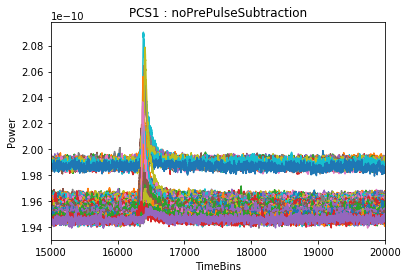

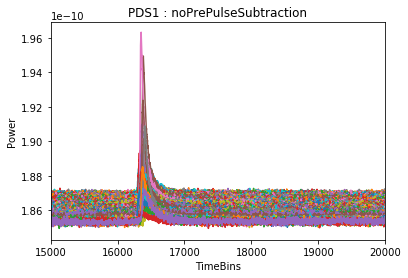

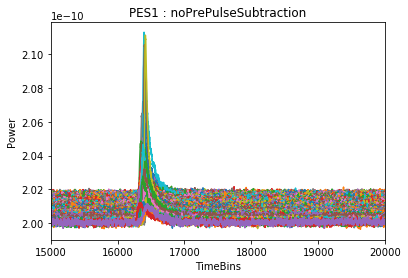

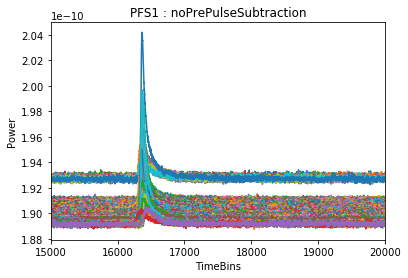

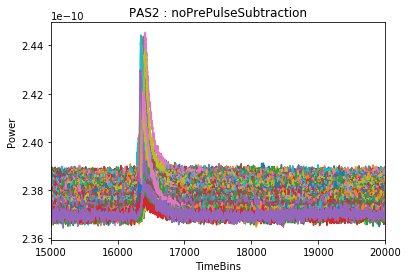

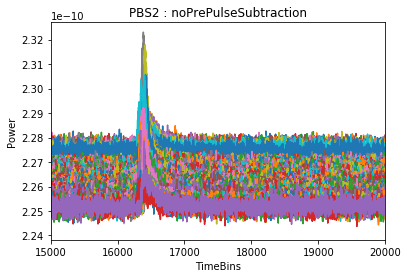

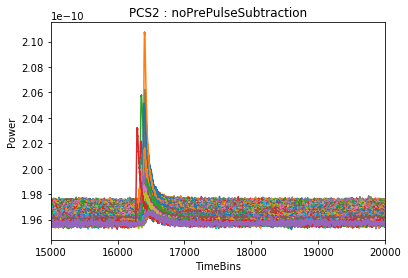

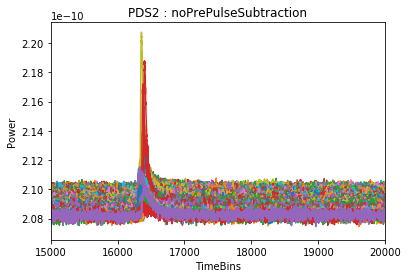

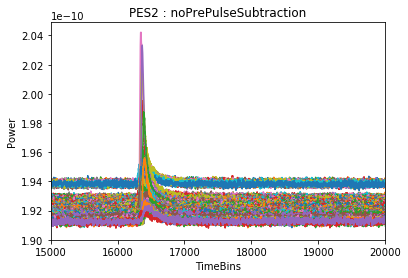

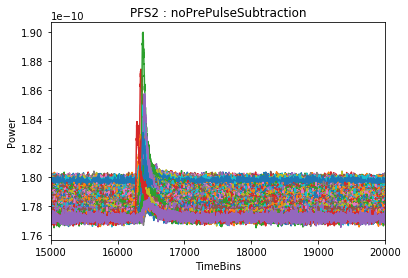

In [25]:
for c in data.keys():
    plt.figure()
    for j in np.arange(len(converted_trace[c])):
        plt.plot(converted_trace[c][j])
    #plt.xlim(15000,17000)
    plt.xlim(15000,20000)
    plt.xlabel('TimeBins')
    plt.ylabel('Power')
    plt.title("%s : noPrePulseSubtraction"%(c))
    plt.savefig('./plots/reverse_cal/selected_events/power_trace_%s_selected_noPrePulseSubtraction.png'%(c))
    plt.show()

In [26]:
prepulse={}
for c in data.keys():
    temp=[]
    for i in np.arange(len(data[c])):
        temp.append(np.mean(converted_trace[c][i][:15000]))
    prepulse[c]=temp
print('Done!')

Done!


In [27]:
converted_trace_shifted={}
for c in data.keys():
    temp=[]
    for i in np.arange(len(converted_trace[c])):
        temp.append(converted_trace[c][i]-prepulse[c][i])
    converted_trace_shifted[c]=temp
print('Done!')

Done!


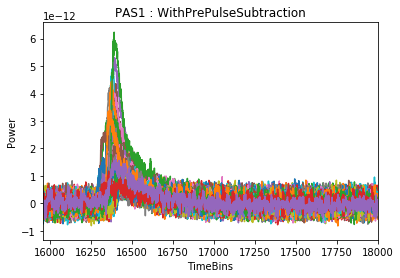

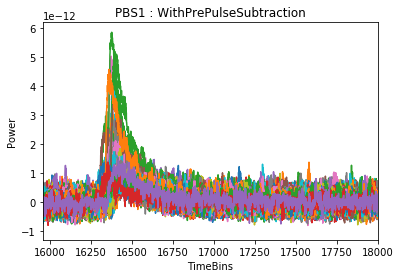

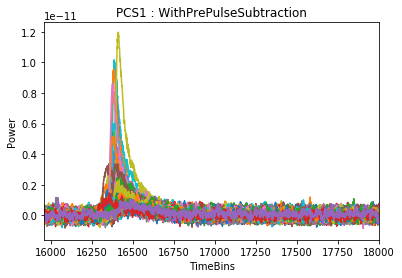

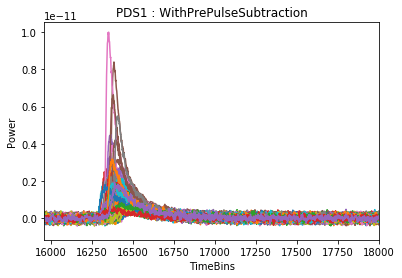

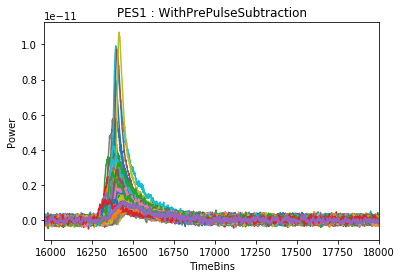

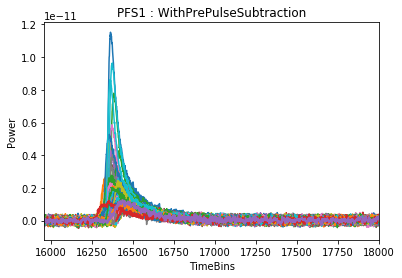

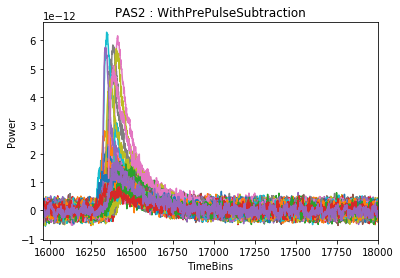

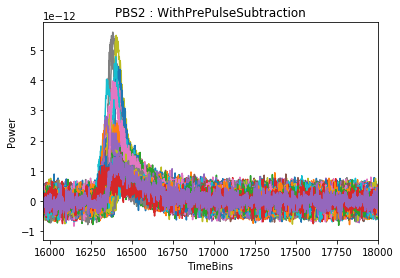

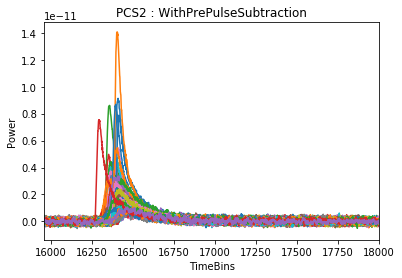

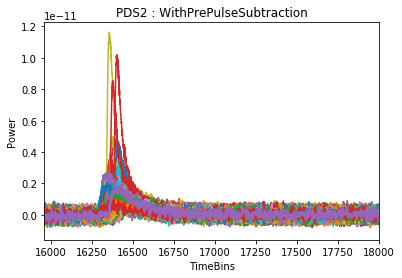

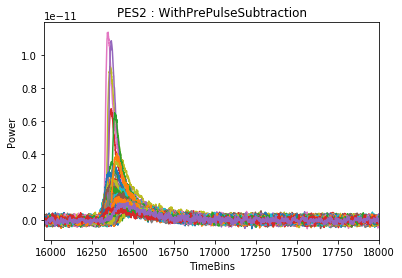

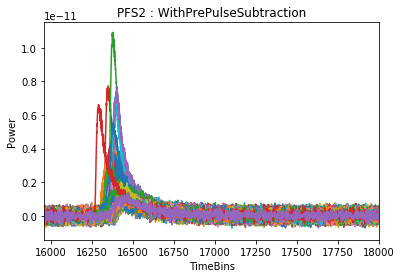

In [29]:
for c in data.keys():
    plt.figure()
    for j in np.arange(len(converted_trace_shifted[c])):
        plt.plot(converted_trace_shifted[c][j])
    #plt.xlim(15000,17000)
    #plt.vlines(16275,0,2.5e-11)
    plt.xlim(15960,18000)
    plt.xlabel('TimeBins')
    plt.ylabel('Power')
    plt.title("%s : WithPrePulseSubtraction"%(c))
    plt.savefig('./plots/reverse_cal/selected_events/power_trace_%s_selected_WithPrePulseSubtraction.png'%(c))
    plt.show()

In [125]:
len(converted_trace_shifted['PAS1'][0])

32768

In [30]:
#Calculating integrated energy using trapezoidal integral. You can also use np.trapz for this instead of writing the innermost for loop
Integrated_energy={}
#nFT=20
#FT=93.4e-6
for c in data.keys():
    temp=[]
    for i in np.arange(len(converted_trace_shifted[c])):
        numsum=0
        for j in np.arange(15960,18000):
            numsum=numsum+0.5*(converted_trace_shifted[c][i][j]+converted_trace_shifted[c][i][j+1])*1.6*1e-6
        temp.append(numsum/(1.602*1e-19*1e3))
    Integrated_energy[c]=temp
print('Done!')

Done!


In [31]:
Integrated_energy['PAS1']

[3.802368922873959,
 5.98385725633412,
 3.139485200698989,
 2.0935427937791022,
 2.482830942075831,
 2.1267516200563352,
 3.471626885707466,
 2.8057850932473603,
 4.592151935521732,
 2.0816196543845074,
 5.190294088255974,
 2.9746153001468594,
 1.7235546925088465,
 3.226173159322163,
 4.930745485935268,
 1.2071234937987152,
 4.347245665512358,
 1.593966154679187,
 4.292932857498578,
 4.252049376187774,
 2.1331269684342127,
 1.669791344422978,
 1.6957528173817635,
 4.078318720821279,
 3.110598005809203,
 3.5670322222081428,
 4.078023486998589,
 3.4550608778846517,
 2.390562564526938,
 3.98521031651459,
 2.6852800388293696,
 3.9813321644798725,
 3.5378086282386336,
 2.7322573400837236,
 7.374641610970908,
 2.570579878610354,
 2.172298213910874,
 3.1483055454762834,
 2.608088552833234,
 5.222353517812026,
 3.097604745587929,
 2.392483143576855,
 3.324538842264518,
 3.3129282228145085,
 4.4407951628926785,
 5.559319127870889,
 2.382495197231437,
 3.431310928454842,
 0.9183795517253541,
 2.

In [32]:
Integrated_energy_net={}
for c in data.keys():
    temp = []
    for j in np.arange(len(Integrated_energy[c])):
        temp.append(Integrated_energy[c][j])
    Integrated_energy_net[c] = temp
print('Done!')

Done!


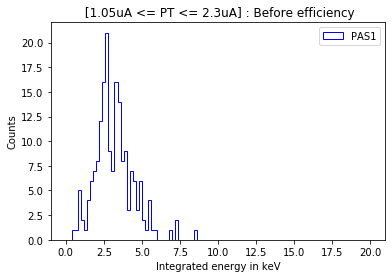

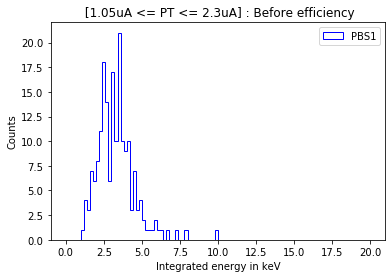

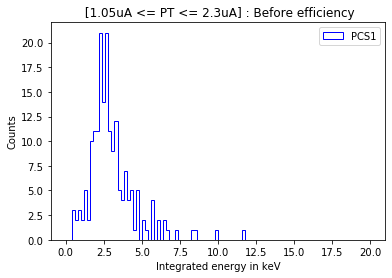

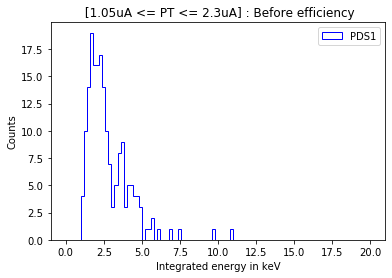

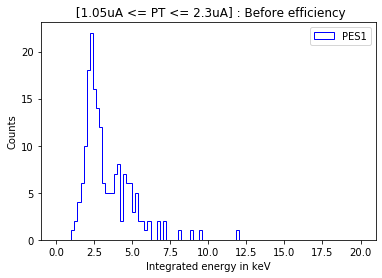

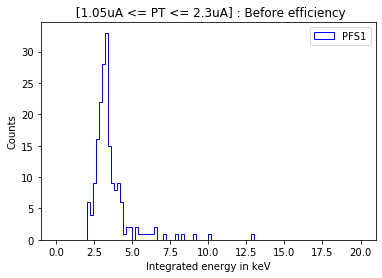

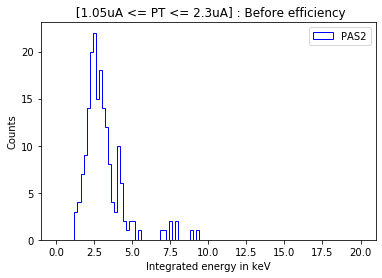

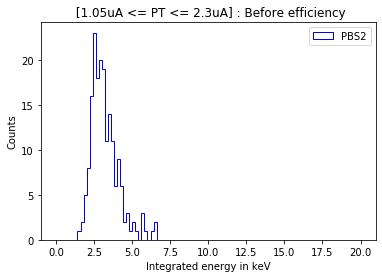

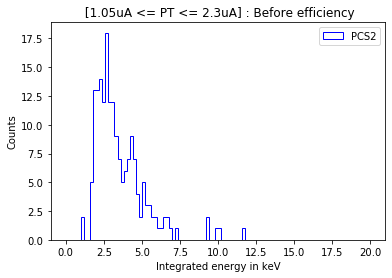

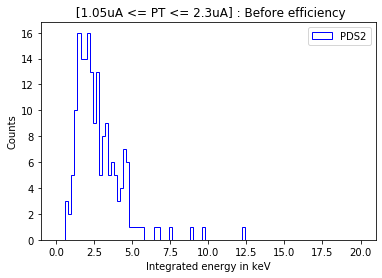

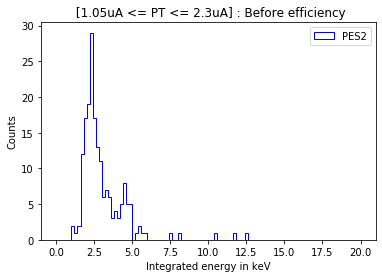

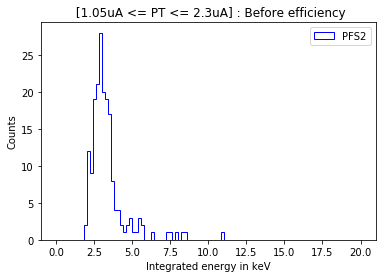

In [34]:
for c in data.keys():
    plt.hist(Integrated_energy_net[c],bins=100,histtype="step", range=[0,20], density=False, color='b', label='%s'%(c))
    plt.xlabel('Integrated energy in keV')
    plt.legend()
    plt.title(' [1.05uA <= PT <= 2.3uA] : Before efficiency')
    plt.ylabel('Counts')
    plt.savefig('./plots/reverse_cal/selected_events/integrated_energy_%s_before_eff.png'%(c))
    #plt.yscale("log")
    plt.show()

In [35]:

h_intE = []

for c in chan:
    if(c=='PT'):
        continue
    hname = 'h_intE_%s'%(c)
    temp = rt.TH1F(hname,hname,75,0,15)
    h_intE.append(temp)

In [36]:
for i,c in enumerate(chan):
    if(c=='PT'):
        continue
    for en in Integrated_energy_net[c]:
        h_intE[i-1].Fill(en)
    print('Done for %s'%(c))

Done for PAS1
Done for PBS1
Done for PCS1
Done for PDS1
Done for PES1
Done for PFS1
Done for PAS2
Done for PBS2
Done for PCS2
Done for PDS2
Done for PES2
Done for PFS2


In [37]:
gaus = []
means = {}
for i,c in enumerate(chan):
    if(c=='PT'):
        continue
    j = i-1
    mean = h_intE[j].GetMean()
    rms = h_intE[j].GetRMS()
    fit_range = [mean - 1.5*rms, mean + 1.5*rms]
    gaus.append(rt.TF1('gaus_%s'%(c),'gaus(0)',fit_range[0],fit_range[1]))
    gaus[j].SetParameters(10, mean, rms)
    h_intE[j].Fit(gaus[j],'Q','',fit_range[0],fit_range[1])
    gaus[j] = h_intE[j].GetFunction('gaus_%s'%(c))
    mean = gaus[j].GetParameter(1)
    rms = gaus[j].GetParameter(2)
    fit_range = [mean - 1.5*rms, mean + 1.5*rms]
    h_intE[j].Fit(gaus[j],'Q','',fit_range[0],fit_range[1])
    gaus[j] = h_intE[j].GetFunction('gaus_%s'%(c))
    mean = gaus[j].GetParameter(1)
    means[c] = mean

print('Done')

Done


Info in <TCanvas::MakeDefCanvas>:  created default TCanvas with name c1


In [38]:
for i,c in enumerate(chan):
    if(c=='PT'):
        continue
    j = i-1
    print('%s =  Mean : efficiency :: %0.2f : %0.2f'%(c, means[c],(means[c]/10.37)*100))

PAS1 =  Mean : efficiency :: 2.83 : 27.33
PBS1 =  Mean : efficiency :: 3.03 : 29.19
PCS1 =  Mean : efficiency :: 2.59 : 25.01
PDS1 =  Mean : efficiency :: 2.08 : 20.03
PES1 =  Mean : efficiency :: 2.52 : 24.29
PFS1 =  Mean : efficiency :: 3.13 : 30.18
PAS2 =  Mean : efficiency :: 2.61 : 25.21
PBS2 =  Mean : efficiency :: 2.88 : 27.73
PCS2 =  Mean : efficiency :: 2.81 : 27.06
PDS2 =  Mean : efficiency :: 2.27 : 21.90
PES2 =  Mean : efficiency :: 2.25 : 21.74
PFS2 =  Mean : efficiency :: 2.96 : 28.57


Info in <TCanvas::Print>: png file ./plots/fitted/PAS1.png has been created
Info in <TCanvas::Print>: png file ./plots/fitted/PBS1.png has been created
Info in <TCanvas::Print>: png file ./plots/fitted/PCS1.png has been created
Info in <TCanvas::Print>: png file ./plots/fitted/PDS1.png has been created
Info in <TCanvas::Print>: png file ./plots/fitted/PES1.png has been created
Info in <TCanvas::Print>: png file ./plots/fitted/PFS1.png has been created
Info in <TCanvas::Print>: png file ./plots/fitted/PAS2.png has been created
Info in <TCanvas::Print>: png file ./plots/fitted/PBS2.png has been created
Info in <TCanvas::Print>: png file ./plots/fitted/PCS2.png has been created
Info in <TCanvas::Print>: png file ./plots/fitted/PDS2.png has been created
Info in <TCanvas::Print>: png file ./plots/fitted/PES2.png has been created
Info in <TCanvas::Print>: png file ./plots/fitted/PFS2.png has been created


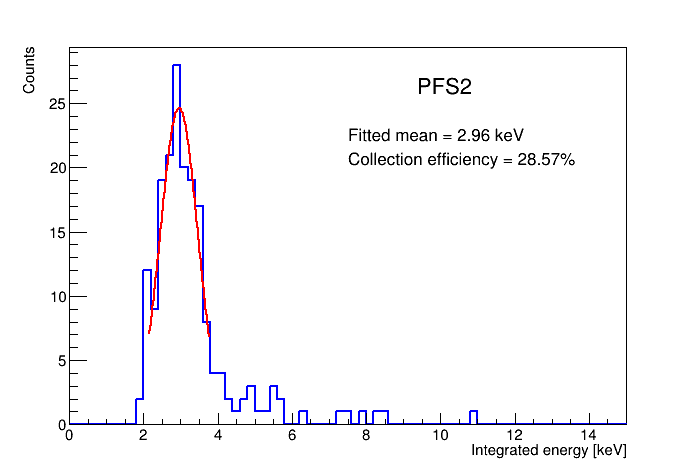

In [39]:
for i in range(12):
    can=rt.TCanvas()
    rt.gStyle.SetOptStat(0)
    c = chan[i+1]
    h_intE[i].SetName('%s'%(c))
    h_intE[i].GetXaxis().SetTitle('Integrated energy [keV]')
    h_intE[i].GetYaxis().SetTitle('Counts')
    h_intE[i].SetTitle('')
    h_intE[i].SetLineColor(rt.kBlue)
    h_intE[i].SetLineWidth(2)
    h_intE[i].Draw()
    textOnTop = rt.TLatex()
    textOnTop.SetTextSize(0.05)
    textOnTop.DrawLatexNDC(0.6,0.8,'#bf{%s}'%(c))
    textOnTop.SetTextSize(0.04)
    textOnTop.DrawLatexNDC(0.5,0.7,'#bf{Fitted mean = %0.2f keV}'%(means[c]))
    textOnTop.DrawLatexNDC(0.5,0.65,'#bf{Collection efficiency = %0.2f%%}'%((means[c]/10.37)*100))
    can.Draw()
    can.SaveAs('./plots/fitted/%s.png'%(c))
    #break